## Handout 2

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

np.random.seed(0)

### Problem 2.1

In [3]:
def draw_random_sample(n_sim, n_periods, alphas):
    """Simulate AR(1) process.
    
    Args:
        n_sim (int): Number of simulations.
        n_periods (int): Number of periods to simulate.
        alphas (float or list-like): Persistency.
        
    Returns:
        process (np.ndarray): Simulated process with shape (n_sim, n_periods, len(alphas))
            if len(alphas) > 1 else (n_sim, n_periods).
    
    """
    alphas = np.atleast_1d(alphas)
    
    innovations = np.random.normal(0, 1, (n_sim, n_periods + 1, len(alphas)))
    innovations[:, 0, :] /= np.sqrt(1 - alphas ** 2)  # adjust variance of e_0
    
    process = innovations.copy()
    for t in range(n_periods):
        process[:, t + 1, :] = process[:, t, :] * alphas + innovations[:, t, :]
    
    process = process[:, 1:, :]
    if len(alphas) == 1:
        process = np.squeeze(process, axis=2)
        
    return process

In [4]:
def least_squares(process):
    """Fit least squares estimator.
    
    Args:
        process (np.ndarray): Process with shape (a, b, c).
        
    Returns:
        coeff (np.ndarray): Coefficients of shape (a, c).
    
    """
    process_lagged = process[:, :-1, :]
    process = process[:, 1:, :]
    
    coeff = (process * process_lagged).sum(axis=1) / (process_lagged ** 2).sum(axis=1)
    
    return coeff

In [5]:
def reformat_data(coeffs, alpha):
    """Reformat coeffcient data to long-format frame.
    
    Args:
        coeffs (np.ndarray or list-like): Estimates of shape (n_sim, len(alphas)) or list
            with elements of shape (n_sim, len(alphas)). In the latter case the number of
            elements must map one-to-one to argument periods and is interpreted as the
            coefficient estimates using different number of periods.
        alphas (float or list-like): Persistency.
    
    Returns:
        df (pd.DataFrame): Tidy long format data frame.
    
    """
    df = pd.concat({key: pd.DataFrame(value) for key, value in coeffs.items()})
    df = df.rename_axis(["n_periods", "n_sim"])

    df = df.set_axis(alphas, axis=1)

    df = df.reset_index(level="n_periods")
    df = df.melt(id_vars="n_periods", var_name="alpha", value_name="estimate")
    return df

In [6]:
def plot_distribution(df, alphas, coverage=None, path=None):
    """Plot distribution of coefficient given alpha.
    
    Args:
        df (pd.DataFrame): Tidy long format data frame.
        alphas (float or list-like): Persistency.
        path (str): Path where to save the image. Not saved if None.
        
    """
    fig, axes = plt.subplots(len(alphas))
    fig.set_size_inches(13, 25)

    for alpha, ax in zip(alphas, axes):
        palette = sns.color_palette("crest", as_cmap=True)
        p = sns.kdeplot(data=df.query("alpha == @alpha"), x="estimate", hue="n_periods", fill=True, palette=palette, ax=ax)

        ax.set(ylabel="Density", xlabel="Estimate")
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
        ax.text(0.05, 0.95, f"alpha = {alpha}", transform=ax.transAxes, fontsize=14, verticalalignment="top", bbox=props)
        ax.set_frame_on(False)
        ax.xaxis.label.set_size(13)
        ax.yaxis.label.set_size(13)
        ax.axvline(alpha, color="black", alpha=0.4)
    
    if path is not None:
        fig.savefig(path, bbox_inches="tight")
    return None

In [7]:
def compute_metrics(coeff, alphas):
    """Compute aggregate metrics of estimates.
    
    Args:
        coeff (np.ndarray or dict): Estimates of shape (n_sim, len(alphas)).
            If dict then keys correspond to n_periods used in the simulation
            and values to corresponding coffficient estimates.
        alphas (float or list-like): Persistency.
        
    Returns:
        metrics (pd.DataFrame): Metrics data frame in long format.
    
    """
    if not isinstance(coeff, dict):
        coeff = {"Unknown": coeff}

    alphas = np.atleast_1d(alphas)

    df = pd.concat({key: pd.DataFrame(value) for key, value in coeffs.items()})
    df = df.rename_axis(["n_period", "n_sim"])

    df_mse = (
        ((df - alphas) ** 2)
        .groupby("n_period")
        .mean()
        .reset_index()
        .melt(id_vars="n_period", var_name="alpha", value_name="estimate")
        .assign(**{"measure": "mse"})
    )
    
    g = df.groupby("n_period")
    
    metrics = g.agg(["mean", "std"])
    metrics = metrics.reset_index()
    metrics = metrics.melt(id_vars="n_period", var_name=["alpha", "measure"], value_name="estimate")
    metrics = pd.concat((df_mse, metrics), axis=0)
    metrics = metrics.sort_values(by=["n_period", "alpha", "measure"])
    metrics = metrics.replace({k: alpha for k, alpha in enumerate(alphas)})
    
    if len(coeffs) == 1:
        metrics = metrics.drop("n_period")
    
    return metrics

In [8]:
def compute_coverage(df):
    df = df.assign(**{"se": np.sqrt(np.abs((1 - df.estimate ** 2)) / df.n_periods)})
    
    left = df.estimate - 1.96 * df.se < df.alpha
    right = df.alpha < df.estimate + 1.96 * df.se
    df = df.assign(**{"coverage": left & right})
    
    coverage = df.groupby(["n_periods", "alpha"])[["coverage"]].mean()
    return coverage

### Now lets get our hands dirty

Takes a few seconds...

In [9]:
alphas = [0.7, 0.8, 0.9, 0.95, 0.99]
n_sim = 10_000
n_periods_list = [200, 500, 800, 1500, 2000]

coeffs = {}
for n_periods in n_periods_list:
    processes = draw_random_sample(n_sim, n_periods, alphas)
    coeff = least_squares(processes)
    coeffs[n_periods] = coeff

In [10]:
metrics = compute_metrics(coeffs, alphas)
df = reformat_data(coeffs, alphas)
coverage = compute_coverage(df)

In [11]:
coverage.unstack()

coverage                                
alpha         0.70    0.80    0.90    0.95    0.99
n_periods                                         
200         0.9483  0.9510  0.9550  0.9594  0.9394
500         0.9484  0.9468  0.9527  0.9506  0.9529
800         0.9540  0.9487  0.9546  0.9513  0.9576
1500        0.9499  0.9538  0.9519  0.9531  0.9593
2000        0.9492  0.9516  0.9508  0.9487  0.9553

In [12]:
# mse
metrics.query("measure == 'mse'").drop("measure", axis=1).set_index(["n_period", "alpha"]).unstack()

estimate                                        
alpha         0.70      0.80      0.90      0.95      0.99
n_period                                                  
200       0.002663  0.001913  0.001104  0.000625  0.000211
500       0.001050  0.000759  0.000408  0.000228  0.000068
800       0.000623  0.000468  0.000239  0.000135  0.000036
1500      0.000345  0.000237  0.000131  0.000068  0.000016
2000      0.000259  0.000179  0.000096  0.000051  0.000012

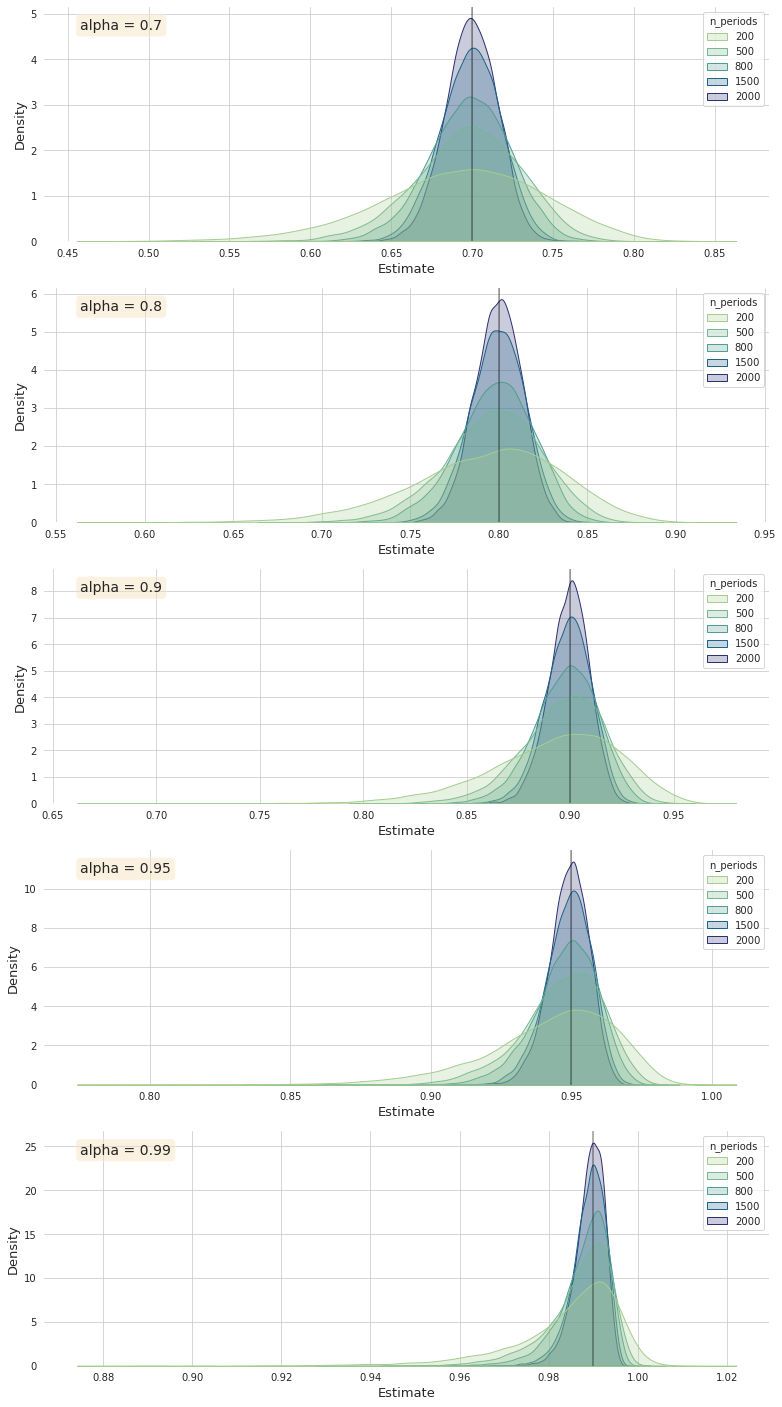

In [13]:
plot_distribution(df, alphas, coverage, "distribution-plot.png")